In [1]:
import numpy as np
from nptyping import NDArray
import random
import numpy.linalg as LA
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple, Optional, Any, Callable
from utils import load_image_to_arr, display_rgb, SVD2D
import dim_reduction
from spectral_data import ImageSpectralData
dim_reduction.init_basis_cache()

16.260803
-0.34007823
-1.0697341
-1.0956047
0.3090999
-0.55229056
0.0
0.0


(540, 960, 3)


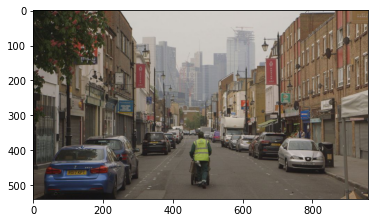

In [6]:
I = load_image_to_arr("street.jpg")
print(I.shape)
display_rgb(I)

In [7]:
class ImageAtScale:
    def __init__(self, imageChunk: NDArray[Any], anchor: Tuple[int, int]):
        self.imageChunk: NDArray[Any] = imageChunk
        self.imageSize: int = imageChunk.shape[0]
        self.anchor: Tuple[int, int] = anchor

        pass


class ImageChunkAttributeSummarizer:
    def __init__(self, chunks: List[ImageAtScale], attribute_size: int, is_metadata: bool, description: str = "no summary"):
        self.description: str = description
        self.chunks: List[ImageAtScale] = chunks
        self.n_chunks: int = len(chunks)
        self.attribute_size = attribute_size
        self.is_metadata = is_metadata
        self.summary: NDArray[Any] = None

    def calculate_summary(self) -> NDArray[Any]:
        pass


class ImageChunkMeanSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], description: str = "Image Chunk RGB Mean"):
        super().__init__(chunks, 3, False, description)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))

    def calculate_summary(self):
        imgs: List[NDArray[Any]] = [c.imageChunk for c in self.chunks]
        for i in range(self.n_chunks):
            img: NDArray[Any] = imgs[i]
            m = np.mean(img, axis=(0, 1))
            self.summary[i] = m

class ImageChunkPrincipleColorSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], principle_color_index: int, description: str = "The nth priciple color and it's standardized length") -> None:
        self.principle_color_index = principle_color_index
        super().__init__(chunks, 4, True, description)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))

    def calculate_summary(self) -> NDArray[Any]:
        for i in range(self.n_chunks):
            img = self.chunks[i].imageChunk
            spec_data = ImageSpectralData(img)
            
            self.summary[i, 0] = spec_data.pc_lengths[self.principle_color_index]
            self.summary[i, 1:] = spec_data.principle_colors[self.principle_color_index]

class ImageChunkPCACoeffSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], pc_index: int, n_coeffs: int):
        self.pc_index: int = pc_index
        self.n_coeffs: int = n_coeffs
        desc = "N PCA coefficients of this image chunks's kth principle color channel"
        super().__init__(chunks, n_coeffs, True, desc)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))

    def calculate_summary(self) -> NDArray[Any]:
        for i in range(self.n_chunks):
            img = self.chunks[i].imageChunk
            spec_data = ImageSpectralData(img)
            print(spec_data.PCMs[i])
            B, coeff = spec_data.get_pcm_pca_coeffs(self.pc_index, self.n_coeffs)
            print(B.basis_vectors)
            print(coeff)
            self.summary[i, :] = coeff

class ImageChunkAnchorSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], description: str = "Image Chunk RGB Mean") -> None:
        super().__init__(chunks, 2, True, description)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))
    
    def calculate_summary(self):
        for i in range(self.n_chunks):
            self.summary[i, 0] = self.chunks[i].anchor[0]
            self.summary[i, 1] = self.chunks[i].anchor[1]

class ImageChunkCenterLocationSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], description: str = "Image Chunk RGB Mean") -> None:
        super().__init__(chunks, 2, False, description)
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))
    
    def calculate_summary(self):
        center_offset = self.chunks[0].imageSize / 2
        for i in range(self.n_chunks):
            self.summary[i, 0] = self.chunks[i].anchor[0] + center_offset
            self.summary[i, 1] = self.chunks[i].anchor[1] + center_offset

class MultiScaleImageChunkSummarizer:
    def __init__(self):
        pass

class ImageChunkSummarizer:
    def __init__(self):
        pass

    def encode_summaries(self, chunks: List[ImageAtScale]):
        pass


class MultiScaleImageSampler:
    def __init__(self, scales: List[int]) -> None:
        #pre-condition: All scales are even numbers.
        self.scales: List[int] = scales
        self.num_scales: int = len(scales)
        self.first_scale = scales[0]

    def sample(self, image: NDArray[Any]) -> List[ImageAtScale]:
        imgY = image.shape[0]
        imgX = image.shape[1]
        anchors: List[Tuple[int, int]] = []
        result: List[ImageAtScale] = []
        
        first_anchor_X = random.randint(0, imgX - self.first_scale)
        first_anchor_Y = random.randint(0, imgY - self.first_scale)
        anchors.append((first_anchor_X, first_anchor_Y))

        for i in range(1, self.num_scales):
            prev_anchor_x, prev_anchor_y = anchors[i-1]
            prev_scale = self.scales[i-1]
            scale = self.scales[i]
            anchor_x = prev_anchor_x + ((prev_scale - scale) // 2)
            anchor_y = prev_anchor_y + ((prev_scale - scale) // 2)
            anchors.append((anchor_x, anchor_y))
    
        for i in range(self.num_scales):
            anchor_x, anchor_y = anchors[i]
            scale = self.scales[i]
            chunk = image[anchor_y:anchor_y+scale, anchor_x:anchor_x+scale, :]
            result.append(ImageAtScale(chunk, anchors[i]))
        
        return result
        

(128, 128, 3) (64, 64, 3) (32, 32, 3) (8, 8, 3)


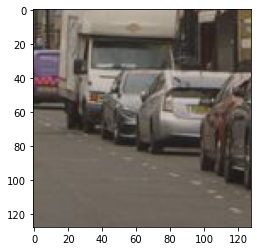

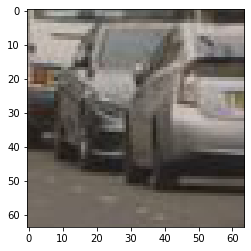

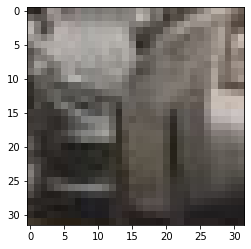

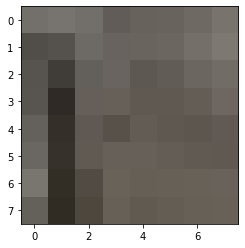

In [8]:
sampler = MultiScaleImageSampler([128, 64, 32, 8])
scales = sampler.sample(I)
print(
    scales[0].imageChunk.shape,
    scales[1].imageChunk.shape,
    scales[2].imageChunk.shape,
    scales[3].imageChunk.shape
)
display_rgb(scales[0].imageChunk)
display_rgb(scales[1].imageChunk)
display_rgb(scales[2].imageChunk)
display_rgb(scales[3].imageChunk)

In [9]:
mean_summarizer = ImageChunkPCACoeffSummarizer([scales[2]], 0, 9)
mean_summarizer.calculate_summary()
mean_summarizer.summary

[[-0.03640969 -0.04218442 -0.00945113 ...  0.04305108  0.02067402
   0.002628  ]
 [ 0.00545706 -0.00753607 -0.00464871 ...  0.02500506  0.00118432
  -0.00964329]
 [ 0.05815142  0.02278123 -0.01475448 ...  0.01417745 -0.01253065
  -0.01469617]
 ...
 [-0.02919129 -0.03786223 -0.04291511 ... -0.04318179 -0.04390363
  -0.04462547]
 [-0.03785337 -0.04724616 -0.04652432 ... -0.04390363 -0.04462547
  -0.04534731]
 [-0.02866678 -0.03227598 -0.03805071 ... -0.04893363 -0.04821179
  -0.04460259]]
[-3.79085541e-03  4.50491905e-03 -9.40092653e-03  7.49627128e-03
 -1.42234564e-02 -1.52764320e-02  2.66376734e-02 -2.87938118e-03
  2.41754055e-02 -2.92024910e-02  3.44758928e-02 -3.27837914e-02
  4.10473347e-03 -3.08005810e-02  3.54176760e-02 -6.79517388e-02
  6.23444915e-02 -3.30705866e-02 -4.54235077e-03 -5.55264950e-03
  5.92282414e-02 -1.24549121e-01  3.11854482e-02 -2.26533413e-02
  6.12126738e-02 -1.47166997e-02  5.17336875e-02 -1.64633200e-01
  4.54795957e-02 -2.91888118e-02  4.24340367e-02 -8.9

array([[ 0.72198789,  0.13653905, -0.07998689, -0.05237455,  0.1328446 ,
         0.01597607, -0.11570554, -0.29404627, -0.09308973]])

In [6]:
import spectral_data

In [2]:
D = spectral_data.ImageSpectralData(scales[1].imageChunk)
pcm1 = D.PCMs[0]
fig, ax = plt.subplots()
ax.imshow(pcm1)

NameError: name 'spectral_data' is not defined

In [30]:
pcm1_flat = pcm1.ravel()
pca_basis = dim_reduction.get_basis(64)
coeffs = pca_basis.get_basis_coeffs(pcm1_flat, 255)
print(coeffs.shape)
pcm1_approx = pca_basis.get_approximation_from_coeffs(coeffs).reshape((128, 128))
fig, ax = plt.subplots()
ax.imshow(pcm1_approx)

ValueError: shapes (4096,) and (16384,255) not aligned: 4096 (dim 0) != 16384 (dim 0)

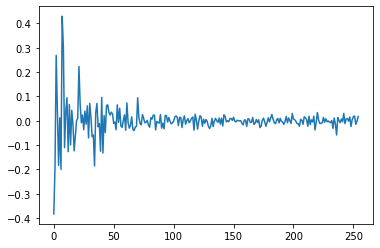

In [29]:
fig, ax = plt.subplots()
ax.plot(coeffs)